# Data Retrieval - Climate data

## CRU Data

### Import packages

In [22]:
import gzip
import os
import shutil
import tempfile
import netCDF4
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import math
import requests
import time
import random
from PIL import Image, ImageDraw, ImageFilter
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import functions

In [7]:
lon = 16.363449
lat = 48.210033

In [8]:
val_nam_list = ['cld', 'dtr', 'frs', 'pet', 'pre', 'tmn', 'tmp', 'tmx', 'vap', 'wet']
fold_n = '/Users/davidschildberger/03_LeWagon_Datasets/CRU_raw_data_2021/'

In [4]:
def get_filename(feat_name):
    fi_n = os.listdir(fold_n)
    fi_n.remove('.DS_Store')
    for i in fi_n: 
        if(feat_name in i) : 
            return i

In [5]:
def open_netcdf(fname):
    with gzip.open((fold_n+fname), 'rb') as f:
        tmp = tempfile.NamedTemporaryFile(delete=False)
        shutil.copyfileobj(f, tmp)

        f.close()
        tmp.close()
        
        data = netCDF4.Dataset(tmp.name)
        os.unlink(tmp.name)
    return data

In [6]:
def retrieve_CRU_data(datatype, year, lon, lat):
    
    data = open_netcdf(get_filename(datatype)) # 0 = 'cld'
    
    year_in_month = (year-1901)*12
    
    c_lat = int(round(np.interp(lat, [-90, 90], [0, 360])))  # check order of values here
    c_lon = int(round(np.interp(lon, [-180, 180], [0, 720])))
    
    temp_dat_date = data.variables[datatype][year_in_month:year_in_month+12,c_lat,c_lon].data
    return temp_dat_date

In [9]:
sp_dat = retrieve_CRU_data('cld', 1980, lon, lat)
sp_dat, sp_dat.mean()

(array([80.5     , 70.9     , 78.5     , 65.9     , 63.2     , 68.1     ,
        65.3     , 57.9     , 52.100002, 65.4     , 78.6     , 71.1     ],
       dtype=float32),
 68.12499)

In [10]:
def retrieve_all_features_mean_CRU_data(year, lon, lat):
    val_nam_list = ['cld', 'dtr', 'frs', 'pet', 'pre', 'tmn', 'tmp', 'tmx', 'vap', 'wet']
    mean_val = []
    for val in val_nam_list:
        mean_val.append(retrieve_CRU_data(val, year, lon, lat).mean())
    return dict(zip(val_nam_list, mean_val))

In [ ]:
retrieve_all_features_mean_CRU_data(1980, lon, lat)

### Bio Variables / slow?!

In [ ]:
## BIO1 = Annual Mean Temperature
def bio_1_annual_mean_temp(year, lon, lat):
    temp_mean = 'tmp'
    return retrieve_CRU_data(temp_mean, year, lon, lat).mean()

In [ ]:
bio_1_annual_mean_temp(1980, lon, lat)

In [ ]:
## Mean Diurnal Range (Mean of monthly (max temp - min temp))
def bio_2_mean_diurnal_range(year, lon, lat):
    t_min = retrieve_CRU_data('tmn', year, lon, lat)
    t_max = retrieve_CRU_data('tmx', year, lon, lat)
    diurnal = t_max-t_min
    return diurnal.mean()

In [ ]:
bio_2_mean_diurnal_range(1980, lon, lat)

In [ ]:
## BIO3 = Isothermality (BIO2/BIO7) (×100)
def bio_3_isothermality(year, lon, lat):
    val = bio_2_mean_diurnal_range(year, lon, lat)/bio_7_temp_range(year, lon, lat)
    return val

In [ ]:
bio_3_isothermality(1980, lon, lat)

In [ ]:
## BIO4 = Temperature Seasonality (standard deviation ×100)
def bio_4_temperature_seasonality(year, lon, lat):
    t_mean = retrieve_CRU_data('tmp', year, lon, lat)
    return np.std(t_mean)

In [ ]:
bio_4_temperature_seasonality(1980, lon, lat)

In [ ]:
## BIO5 = Max Temperature of Warmest Month
def bio_5_max_temp_of_max_month(year, lon, lat):
    t_max = retrieve_CRU_data('tmx', year, lon, lat)
    return np.max(t_max)

In [ ]:
bio_5_max_temp_of_max_month(1980, lon, lat)

In [ ]:
## BIO6 = Min Temperature of Coldest Month
def bio_6_min_temp_of_min_month(year, lon, lat):
    t_min = retrieve_CRU_data('tmn', year, lon, lat)
    return np.min(t_min)

In [ ]:
bio_6_min_temp_of_min_month(1980, lon, lat)

In [ ]:
## BIO7 = Temperature Annual Range (BIO5-BIO6)
def bio_7_temp_range(year, lon, lat):
    rang_temp = bio_5_max_temp_of_max_month(year, lon, lat)-bio_6_min_temp_of_min_month(year, lon, lat)
    return rang_temp

In [ ]:
bio_7_temp_range(1980, lon, lat)

In [ ]:
## BIO8 = Mean Temperature of Wettest Quarter
def bio_8_mean_temp_wet_q(year, lon, lat):
    temp_wet = retrieve_CRU_data('wet', year, lon, lat)
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(temp_wet[i:i+3].sum())
    max_index=li_temp.index(max(li_temp))
    ll = [0,3,6,9]
    st = ll[max_index]
    return retrieve_CRU_data('tmp', year, lon, lat)[st:st+3].mean()

In [ ]:
bio_8_mean_temp_wet_q(1980, lon, lat)

In [ ]:
## BIO9 = Mean Temperature of Driest Quarter
def bio_9_mean_temp_dry_q(year, lon, lat):
    temp_wet = retrieve_CRU_data('wet', year, lon, lat)
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(temp_wet[i:i+3].sum())
    min_index=li_temp.index(min(li_temp))
    ll = [0,3,6,9]
    st = ll[min_index]
    return retrieve_CRU_data('tmp', year, lon, lat)[st:st+3].mean()

In [ ]:
bio_9_mean_temp_dry_q(1980, lon, lat)

In [ ]:
## BIO10 = Mean Temperature of Warmest Quarter
def bio_10_mean_temp_warm_q(year, lon, lat):
    temp_wet = retrieve_CRU_data('tmp', year, lon, lat)
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(temp_wet[i:i+3].sum())
    max_index=li_temp.index(max(li_temp))
    ll = [0,3,6,9]
    st = ll[max_index]
    return temp_wet[st:st+3].mean()

In [ ]:
bio_10_mean_temp_warm_q(1980, lon, lat)

In [ ]:
## BIO11 = Mean Temperature of Coldest Quarter
def bio_11_mean_temp_cold_q(year, lon, lat):
    temp_wet = retrieve_CRU_data('tmp', year, lon, lat)
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(temp_wet[i:i+3].sum())
    min_index=li_temp.index(min(li_temp))
    ll = [0,3,6,9]
    st = ll[min_index]
    return temp_wet[st:st+3].mean()

In [ ]:
bio_11_mean_temp_cold_q(1980, lon, lat)

In [ ]:
## BIO12 = Annual Precipitation
def bio_12_annual_prec(year, lon, lat):
    return retrieve_CRU_data('pre', year, lon, lat).sum()

In [ ]:
bio_12_annual_prec(1980, lon, lat)

In [ ]:
## BIO13 = Precipitation of Wettest Month
def bio_13_prec_wet_mo(year, lon, lat):
    temp_wet = retrieve_CRU_data('wet', year, lon, lat)
    max_index=np.argmax(temp_wet)
    return retrieve_CRU_data('pre', year, lon, lat)[max_index]

In [ ]:
bio_13_prec_wet_mo(1980, lon, lat)

In [ ]:
## BIO14 = Precipitation of Driest Month
def bio_14_prec_dry_mo(year, lon, lat):
    temp_wet = retrieve_CRU_data('wet', year, lon, lat)
    min_index=np.argmin(temp_wet)
    return retrieve_CRU_data('pre', year, lon, lat)[min_index]

In [ ]:
bio_14_prec_dry_mo(1980, lon, lat)

In [ ]:
## BIO15 = Precipitation Seasonality (Coefficient of Variation)
def bio_15_prec_wet_mo(year, lon, lat):
    temp_pre = retrieve_CRU_data('pre', year, lon, lat)
    cv = lambda x: np.std(temp_pre, ddof=1) / np.mean(temp_pre) * 100
    return cv(temp_pre)

In [ ]:
bio_15_prec_wet_mo(1980, lon, lat)

In [ ]:
## BIO16 = Precipitation of Wettest Quarter
def bio_16_pre_wet_q(year, lon, lat):
    temp_wet = retrieve_CRU_data('wet', year, lon, lat)
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(temp_wet[i:i+3].sum())
    max_index=li_temp.index(max(li_temp))
    ll = [0,3,6,9]
    st = ll[max_index]
    return retrieve_CRU_data('pre', year, lon, lat)[st:st+3].mean()

In [ ]:
bio_16_pre_wet_q(1980, lon, lat)

In [ ]:
## BIO17 = Precipitation of Driest Quarter
def bio_17_pre_dry_q(year, lon, lat):
    temp_wet = retrieve_CRU_data('wet', year, lon, lat)
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(temp_wet[i:i+3].sum())
    min_index=li_temp.index(min(li_temp))
    ll = [0,3,6,9]
    st = ll[min_index]
    return retrieve_CRU_data('pre', year, lon, lat)[st:st+3].mean()

In [ ]:
bio_17_pre_dry_q(1980, lon, lat)

In [ ]:
## BIO18  Precipitation of Warmest Quarter...
def bio_18_pre_dry_q(year, lon, lat):
    temp_wet = retrieve_CRU_data('tmp', year, lon, lat)
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(temp_wet[i:i+3].sum())
    max_index=li_temp.index(max(li_temp))
    ll = [0,3,6,9]
    st = ll[max_index]
    return retrieve_CRU_data('pre', year, lon, lat)[st:st+3].mean()

In [ ]:
bio_18_pre_dry_q(1980, lon, lat)

In [ ]:
## BIO19 = Precipitation of Coldest Quarter...
def bio_19_pre_cld_q(year, lon, lat):
    temp_wet = retrieve_CRU_data('tmp', year, lon, lat)
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(temp_wet[i:i+3].sum())
    min_index=li_temp.index(min(li_temp))
    ll = [0,3,6,9]
    st = ll[min_index]
    return retrieve_CRU_data('pre', year, lon, lat)[st:st+3].mean()

In [ ]:
bio_19_pre_cld_q(1980, lon, lat)

In [ ]:
def get_bioclim_var(year, lon, lat):
    temp_li = []
    temp_li.append(bio_1_annual_mean_temp(year, lon, lat))
    temp_li.append(bio_2_mean_diurnal_range(year, lon, lat))
    temp_li.append(bio_3_isothermality(year, lon, lat))
    temp_li.append(bio_4_temperature_seasonality(year, lon, lat))
    temp_li.append(bio_5_max_temp_of_max_month(year, lon, lat))
    temp_li.append(bio_6_min_temp_of_min_month(year, lon, lat))
    temp_li.append(bio_7_temp_range(year, lon, lat))
    temp_li.append(bio_8_mean_temp_wet_q(year, lon, lat))
    temp_li.append(bio_9_mean_temp_dry_q(year, lon, lat))
    temp_li.append(bio_10_mean_temp_warm_q(year, lon, lat))
    temp_li.append(bio_11_mean_temp_cold_q(year, lon, lat))
    temp_li.append(bio_12_annual_prec(year, lon, lat))
    temp_li.append(bio_13_prec_wet_mo(year, lon, lat))
    temp_li.append(bio_14_prec_dry_mo(year, lon, lat))
    temp_li.append(bio_15_prec_wet_mo(year, lon, lat))
    temp_li.append(bio_16_pre_wet_q(year, lon, lat))
    temp_li.append(bio_17_pre_dry_q(year, lon, lat))
    temp_li.append(bio_18_pre_cld_q(year, lon, lat))
    temp_li.append(bio_19_pre_cld_q(year, lon, lat))
    return temp_li

In [ ]:
get_bioclim_var(1980, lon, lat)

### Bio variables / optimized

In [14]:
def retrieve_CRU_data_all(datatype, year):
    data = open_netcdf(get_filename(datatype))
    year_in_month = (year-1901)*12
    return data.variables[datatype][year_in_month:year_in_month+12,:,:].data

In [15]:
dat_t = retrieve_CRU_data_all('cld', 1980)
dat_t.shape

(12, 360, 720)

In [16]:
def retrieve_all_features_CRU_data(year):
    val_nam_list = ['cld', 'dtr', 'frs', 'pet', 'pre', 'tmn', 'tmp', 'tmx', 'vap', 'wet']
    val_t = []
    for val in val_nam_list:
        val_t.append(retrieve_CRU_data_all(val, year))
    return np.array(val_t)

In [ ]:
dat_ = retrieve_all_features_mean_CRU_data(1980)
dat_

In [ ]:
dat_.shape

In [ ]:
def retrieve_all_features_all_years_CRU_data(year_start, year_stop):
    val_nam_list = ['cld', 'dtr', 'frs', 'pet', 'pre', 'tmn', 'tmp', 'tmx', 'vap', 'wet']
    
    year_start_in_month = (year_start-1901)*12
    year_stop_in_month = (year_stop-1901)*12
    
    val_t = []
    for val in val_nam_list:
        data = open_netcdf(get_filename(val))
        val_t.append(data.variables[val][year_start_in_month:year_stop_in_month,:,:].data)
    return np.array(val_t)

In [ ]:
dt = retrieve_all_features_all_years_CRU_data(1980,1982)
dt.shape

In [ ]:
plt.imshow(np.flip(dt[0,0,:,:],0));

### Bio variables / individual features

In [ ]:
## BIO1 = Annual Mean Temperature
def bio_1(year):
    val = 'tmp'
    data = open_netcdf(get_filename(val))
    
    year_in_month = (year-1901)*12
    
    d = data.variables[val][year_in_month:year_in_month+12,:,:].data.mean(axis=0)
    d[d > 99999] = np.nan
    res = np.flip(d,0)
    res = np.around(val, decimals=2)
    return res

In [19]:
b1 = bio_1(1980)
b1.shape

(360, 720)

In [30]:
np.nanmin(b1), np.nanmax(b1)

(-30.183334, 31.358335)

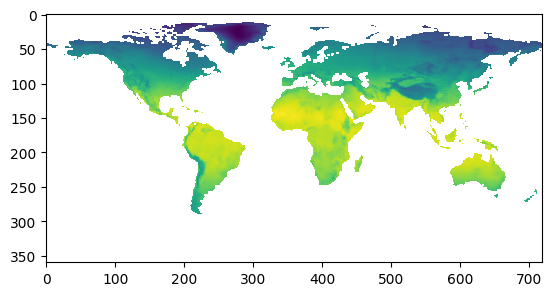

In [23]:
plt.imshow(b1);

In [ ]:
## Mean Diurnal Range (Mean of monthly (max temp - min temp))
def bio_2(year):
    data_tmn = open_netcdf(get_filename('tmn'))
    data_tmx = open_netcdf(get_filename('tmx'))
    year_in_month = (year-1901)*12
    
    t_min = data_tmn.variables['tmn'][year_in_month:year_in_month+12,:,:].data
    t_max = data_tmx.variables['tmx'][year_in_month:year_in_month+12,:,:].data
    t_min[t_min > 255] = np.nan
    t_max[t_max > 255] = np.nan
    d = t_max - t_min
    d = d.mean(axis=0)
    d[d > 99999] = np.nan
    res = np.flip(d,0)
    res = np.around(val, decimals=2)
    return res

In [33]:
b2 = bio_2(1980)
b2.shape

(360, 720)

In [34]:
np.nanmin(b2), np.nanmax(b2)

(3.2000008, 20.800001)

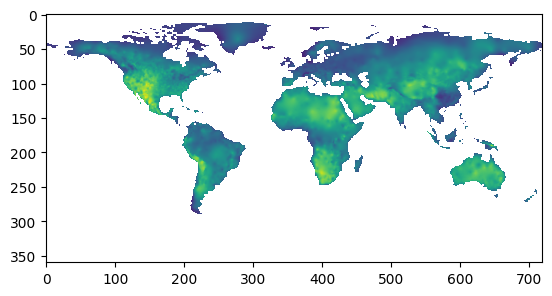

In [35]:
plt.imshow(b2);

In [312]:
## BIO3 = Isothermality (BIO2/BIO7) (×100)
def bio_3(year):
    val = bio_2(year)/bio_7(year)
    val[val > 50000] = np.nan
    res = np.around(val, decimals=2)
    return res

In [313]:
b3 = bio_3(1980)
b3.shape

(360, 720)

In [314]:
np.nanmin(b3), np.nanmax(b3)

(0.12, 0.93)

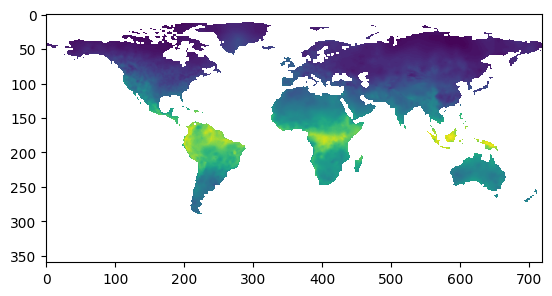

In [315]:
plt.imshow(b3);

In [320]:
## BIO4 = Temperature Seasonality (standard deviation ×100)
def bio_4(year):
    data = open_netcdf(get_filename('tmp'))

    year_in_month = (year-1901)*12
    
    t_mp = data.variables['tmp'][year_in_month:year_in_month+12,:,:].data
    t_mp[t_mp > 50000] = np.nan
    res = np.std(t_mp, axis=0)
    res = np.flip(res,0)
    res = np.around(res, decimals=2)
    return res

In [40]:
b4 = bio_4(1980)
b4.shape

(360, 720)

In [41]:
np.nanmin(b4), np.nanmax(b4)

(0.12133482, 22.908785)

In [ ]:
plt.imshow(b4);

In [308]:
## BIO5 = Max Temperature of Warmest Month
def bio_5(year):
    data = open_netcdf(get_filename('tmx'))

    year_in_month = (year-1901)*12
    
    t_max = data.variables['tmx'][year_in_month:year_in_month+12,:,:].data
    t_max[t_max > 50000] = np.nan
    res = np.max(t_max, axis=0)
    res = np.flip(res,0)
    res = np.around(res, decimals=2)
    return res

In [44]:
b5 = bio_5(1980)
b5.shape

(360, 720)

In [45]:
np.nanmin(b5), np.nanmax(b5)

(-9.6, 46.4)

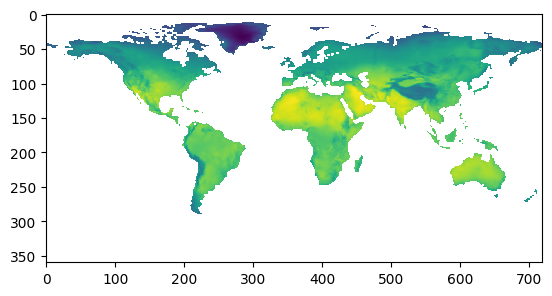

In [46]:
plt.imshow(b5);

In [311]:
## BIO6 = Min Temperature of Coldest Month
def bio_6(year):
    data = open_netcdf(get_filename('tmn'))

    year_in_month = (year-1901)*12
    
    t_min = data.variables['tmn'][year_in_month:year_in_month+12,:,:].data
    t_min[t_min > 50000] = np.nan
    res = np.min(t_min, axis=0)
    res = np.flip(res,0)
    res = np.around(res, decimals=2)
    return res

In [49]:
b6 = bio_6(1980)
b6.shape

(360, 720)

In [50]:
np.nanmin(b6), np.nanmax(b6)

(-51.2, 25.300001)

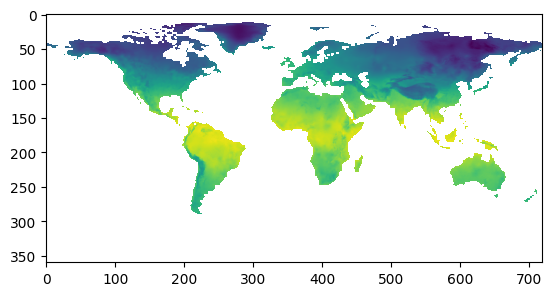

In [51]:
plt.imshow(b6);

In [305]:
## BIO7 = Temperature Annual Range (BIO5-BIO6)
def bio_7(year):
    rang_temp = bio_5(1980)-bio_6(1980)
    rang_temp[rang_temp > 50000] = np.nan
    res = np.around(rang_temp, decimals=2)
    return res

In [295]:
b7 = bio_7(1980)
b7.shape

(360, 720)

In [296]:
np.nanmin(b7), np.nanmax(b7)

(6.1, 72.6)

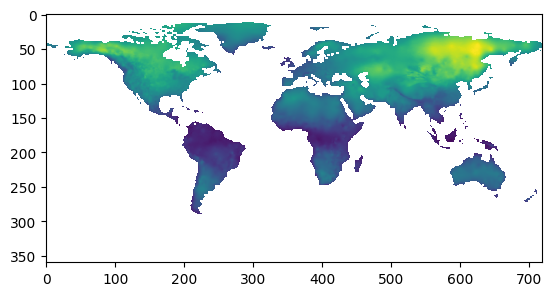

In [297]:
plt.imshow(b7);

In [293]:
## BIO8 = Mean Temperature of Wettest Quarter
def bio_8(year):
    data_wet = open_netcdf(get_filename('wet'))
    data_tmp = open_netcdf(get_filename('tmp'))
    
    year_in_month = (year-1901)*12
    
    temp_wet =  data_wet.variables['wet'][year_in_month:year_in_month+12,:,:].data
    
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(np.sum(temp_wet[i:i+3], axis=0))
    li_temp = np.array(li_temp)
    max_ind = np.argmax(li_temp, axis=0)
    
    li_q_t = []
    for i in range(0,11,3):
        li_q_t.append(np.mean(data_tmp.variables['tmp'][year_in_month+i:year_in_month+i+3,:,:].data, axis=0))

    li_q_t = np.array(li_q_t)
    
    res = np.choose(max_ind, li_q_t)
    res[res > 50000] = np.nan
    res = np.flip(res,0)
    res = np.around(res, decimals=2)
    return res

In [57]:
b8 = bio_8(1980)
b8.shape

(360, 720)

In [58]:
np.nanmin(b8), np.nanmax(b8)

(-42.266666, 35.86667)

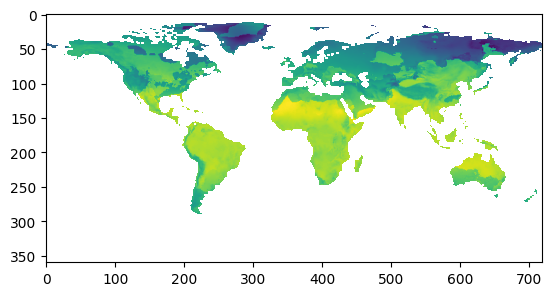

In [59]:
plt.imshow(b8);

In [292]:
## BIO9 = Mean Temperature of Driest Quarter
def bio_9(year):
    data_wet = open_netcdf(get_filename('wet'))
    data_tmp = open_netcdf(get_filename('tmp'))
    
    year_in_month = (year-1901)*12
    
    temp_wet =  data_wet.variables['wet'][year_in_month:year_in_month+12,:,:].data
    
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(np.sum(temp_wet[i:i+3], axis=0))
    li_temp = np.array(li_temp)
    min_ind = np.argmin(li_temp, axis=0)
    
    li_q_t = []
    for i in range(0,11,3):
        li_q_t.append(np.mean(data_tmp.variables['tmp'][year_in_month+i:year_in_month+i+3,:,:].data, axis=0))

    li_q_t = np.array(li_q_t)
    
    res = np.choose(min_ind, li_q_t)
    res[res > 50000] = np.nan
    res = np.flip(res,0)
    res = np.around(res, decimals=2)
    return res

In [61]:
b9 = bio_9(1980)
b9.shape

(360, 720)

In [62]:
np.nanmin(b9), np.nanmax(b9)

(-38.8, 35.933334)

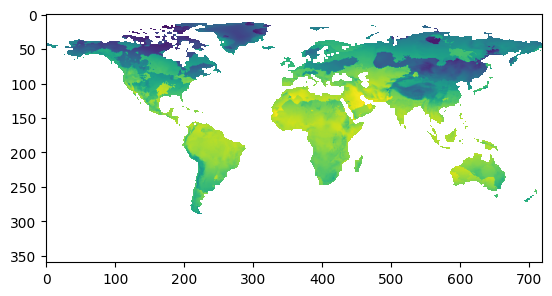

In [63]:
plt.imshow(b9);

In [291]:
## BIO10 = Mean Temperature of Warmest Quarter
def bio_10(year):
    data_wet = open_netcdf(get_filename('tmx'))
    data_tmp = open_netcdf(get_filename('tmp'))
    
    year_in_month = (year-1901)*12
    
    temp_wet =  data_wet.variables['tmx'][year_in_month:year_in_month+12,:,:].data
    
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(np.sum(temp_wet[i:i+3], axis=0))
    li_temp = np.array(li_temp)
    max_ind = np.argmax(li_temp, axis=0)
    
    li_q_t = []
    for i in range(0,11,3):
        li_q_t.append(np.mean(data_tmp.variables['tmp'][year_in_month+i:year_in_month+i+3,:,:].data, axis=0))

    li_q_t = np.array(li_q_t)
    
    res = np.choose(max_ind, li_q_t)
    res[res > 50000] = np.nan
    res = np.flip(res,0)
    res = np.around(res, decimals=2)
    return res

In [66]:
b10 = bio_10(1980)
b10.shape

(360, 720)

In [70]:
np.nanmin(b10), np.nanmax(b10)

(-18.633333, 36.0)

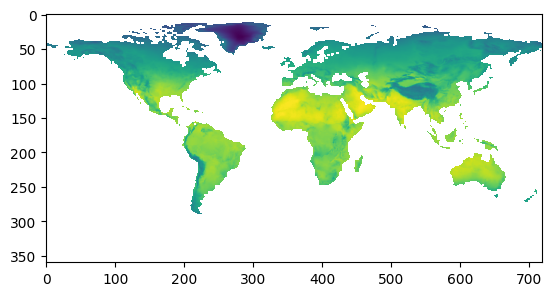

In [68]:
plt.imshow(b10);

In [290]:
## BIO11 = Mean Temperature of Coldest Quarter
def bio_11(year):
    data_wet = open_netcdf(get_filename('tmn'))
    data_tmp = open_netcdf(get_filename('tmp'))
    
    year_in_month = (year-1901)*12
    
    temp_wet =  data_wet.variables['tmn'][year_in_month:year_in_month+12,:,:].data
    
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(np.sum(temp_wet[i:i+3], axis=0))
    li_temp = np.array(li_temp)
    min_ind = np.argmin(li_temp, axis=0)
    
    li_q_t = []
    for i in range(0,11,3):
        li_q_t.append(np.mean(data_tmp.variables['tmp'][year_in_month+i:year_in_month+i+3,:,:].data, axis=0))

    li_q_t = np.array(li_q_t)
    
    res = np.choose(min_ind, li_q_t)
    res[res > 50000] = np.nan
    res = np.flip(res,0)
    res = np.around(res, decimals=2)
    return res

In [71]:
b11 = bio_11(1980)

In [72]:
b11.shape

(360, 720)

In [73]:
np.nanmin(b11), np.nanmax(b11)

(-43.933334, 29.666666)

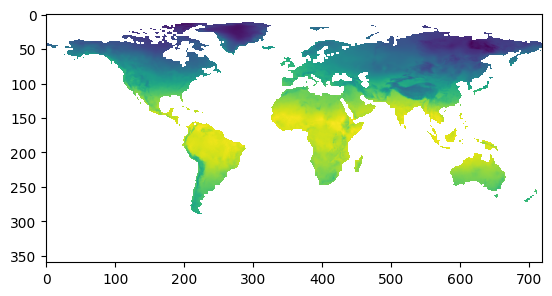

In [74]:
plt.imshow(b11);

In [289]:
## BIO12 = Annual Precipitation
def bio_12(year):
    data_pre = open_netcdf(get_filename('pre'))
    
    year_in_month = (year-1901)*12
    
    temp_wet =  data_pre.variables['pre'][year_in_month:year_in_month+12,:,:].data
    temp_wet[temp_wet > 50000000] = np.nan
    temp_wet = np.sum(temp_wet, axis=0)
    res = np.flip(temp_wet,0)
    res = np.around(res, decimals=2)
    return res

In [76]:
b12 = bio_12(1980)
b12.shape

(360, 720)

In [77]:
np.nanmin(b12), np.nanmax(b12)

(0.0, 6572.8003)

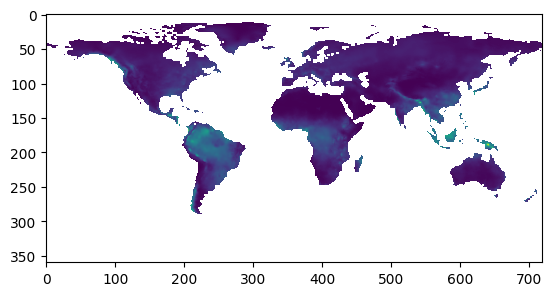

In [78]:
plt.imshow(b12);

In [288]:
## BIO13 = Precipitation of Wettest Month
def bio_13(year):
    data_wet = open_netcdf(get_filename('wet'))
    data_tmp = open_netcdf(get_filename('pre'))
    
    year_in_month = (year-1901)*12
    
    temp_wet =  data_wet.variables['wet'][year_in_month:year_in_month+12,:,:].data
    
    max_ind = np.argmax(temp_wet, axis=0)
        
    res = np.choose(max_ind, data_tmp.variables['pre'][year_in_month:year_in_month+12,:,:].data)
    res[res > 50000] = np.nan
    res = np.flip(res,0)
    res = np.around(res, decimals=2)
    return res

In [80]:
b13 = bio_13(1980)
b13.shape

(360, 720)

In [83]:
np.nanmin(b13), np.nanmax(b13)

(0.0, 2337.3)

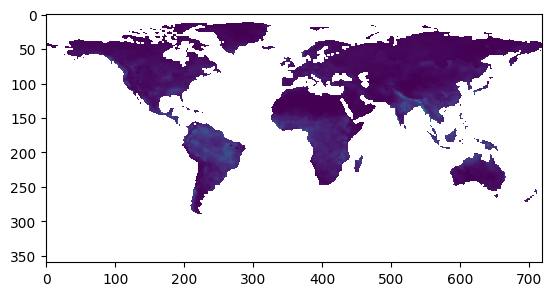

In [82]:
plt.imshow(b13);

In [287]:
## BIO14 = Precipitation of Driest Month
def bio_14(year):
    data_wet = open_netcdf(get_filename('wet'))
    data_tmp = open_netcdf(get_filename('pre'))
    
    year_in_month = (year-1901)*12
    
    temp_wet =  data_wet.variables['wet'][year_in_month:year_in_month+12,:,:].data
    
    min_ind = np.argmin(temp_wet, axis=0)
        
    res = np.choose(min_ind, data_tmp.variables['pre'][year_in_month:year_in_month+12,:,:].data)
    res[res > 50000] = np.nan
    res = np.flip(res,0)
    res = np.around(res, decimals=2)
    return res

In [85]:
b14 = bio_14(1980)
b14.shape

(360, 720)

In [86]:
np.nanmin(b14), np.nanmax(b14)

(0.0, 496.7)

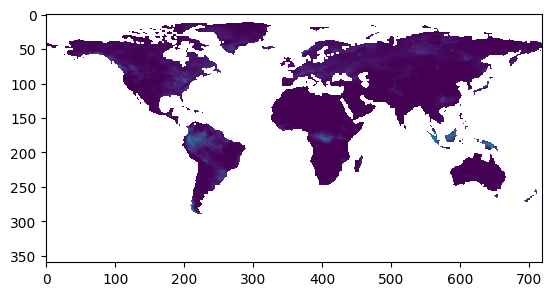

In [87]:
plt.imshow(b14);

In [286]:
## BIO15 = Precipitation Seasonality (Coefficient of Variation)
def bio_15(year):
    val = 'pre'
    data = open_netcdf(get_filename(val))
    
    year_in_month = (year-1901)*12
    
    d = data.variables[val][year_in_month:year_in_month+12,:,:].data
    d[d > 500000] = np.nan
    cv = lambda x: np.std(d, ddof=1, axis=0) / np.mean(d, axis=0) * 100
    d = cv(d)
    res = np.flip(d,0)
    res = np.around(res, decimals=2)
    return res

In [89]:
b15 = bio_15(1980)
b15.shape

/var/folders/jj/6lhmrlt15xs297nzzcs7734w0000gn/T/ipykernel_29092/2129893429.py:10: RuntimeWarning: invalid value encountered in divide
  cv = lambda x: np.std(d, ddof=1, axis=0) / np.mean(d, axis=0) * 100


(360, 720)

In [90]:
np.nanmin(b15), np.nanmax(b15)

(1.5563752e-05, 346.41016)

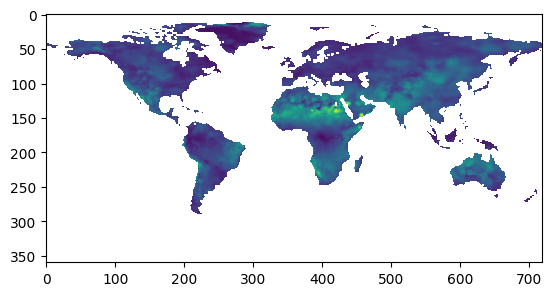

In [91]:
plt.imshow(b15);

In [285]:
## BIO16 = Precipitation of Wettest Quarter
def bio_16(year):
    data_wet = open_netcdf(get_filename('wet'))
    data_tmp = open_netcdf(get_filename('pre'))
    
    year_in_month = (year-1901)*12
    
    temp_wet =  data_wet.variables['wet'][year_in_month:year_in_month+12,:,:].data
    
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(np.sum(temp_wet[i:i+3], axis=0))
    li_temp = np.array(li_temp)
    max_ind = np.argmax(li_temp, axis=0)
    
    li_q_t = []
    for i in range(0,11,3):
        li_q_t.append(np.sum(data_tmp.variables['pre'][year_in_month+i:year_in_month+i+3,:,:].data, axis=0))

    li_q_t = np.array(li_q_t)
    
    res = np.choose(max_ind, li_q_t)
    res[res > 500000] = np.nan
    res = np.flip(res,0)
    res = np.around(res, decimals=2)
    return res

In [93]:
b16 = bio_16(1980)
b16.shape

(360, 720)

In [94]:
np.nanmin(b16), np.nanmax(b16)

(0.0, 3658.5)

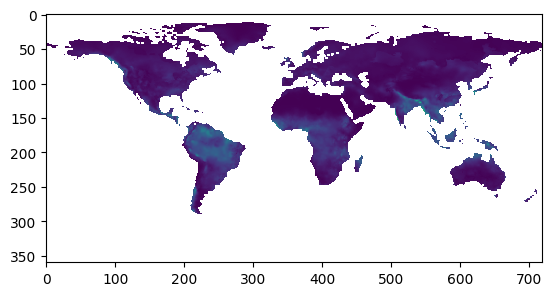

In [95]:
plt.imshow(b16);

In [284]:
## BIO17 = Precipitation of Driest Quarter
def bio_17(year):
    data_wet = open_netcdf(get_filename('wet'))
    data_tmp = open_netcdf(get_filename('pre'))
    
    year_in_month = (year-1901)*12
    
    temp_wet =  data_wet.variables['wet'][year_in_month:year_in_month+12,:,:].data
    
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(np.sum(temp_wet[i:i+3], axis=0))
    li_temp = np.array(li_temp)
    min_ind = np.argmin(li_temp, axis=0)
    
    li_q_t = []
    for i in range(0,11,3):
        li_q_t.append(np.sum(data_tmp.variables['pre'][year_in_month+i:year_in_month+i+3,:,:].data, axis=0))

    li_q_t = np.array(li_q_t)
    
    res = np.choose(min_ind, li_q_t)
    res[res > 500000] = np.nan
    res = np.flip(res,0)
    res = np.around(res, decimals=2)
    return res

In [97]:
b17 = bio_17(1980)
b17.shape

(360, 720)

In [98]:
np.nanmin(b17), np.nanmax(b17)

(0.0, 1718.6001)

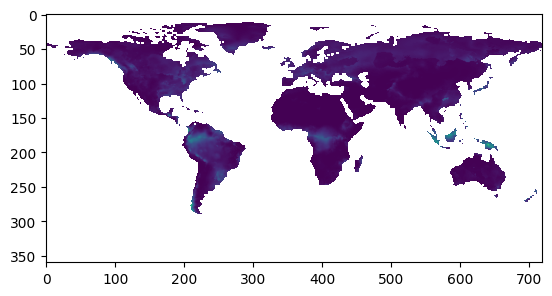

In [99]:
plt.imshow(b17);

In [283]:
## BIO18  Precipitation of Warmest Quarter...
def bio_18(year):
    data_wet = open_netcdf(get_filename('tmp'))
    data_tmp = open_netcdf(get_filename('pre'))
    
    year_in_month = (year-1901)*12
    
    temp_wet =  data_wet.variables['tmp'][year_in_month:year_in_month+12,:,:].data
    
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(np.sum(temp_wet[i:i+3], axis=0))
    li_temp = np.array(li_temp)
    max_ind = np.argmax(li_temp, axis=0)
    
    li_q_t = []
    for i in range(0,11,3):
        li_q_t.append(np.sum(data_tmp.variables['pre'][year_in_month+i:year_in_month+i+3,:,:].data, axis=0))

    li_q_t = np.array(li_q_t)
    
    res = np.choose(max_ind, li_q_t)
    res[res > 500000] = np.nan
    res = np.flip(res,0)
    res = np.around(res, decimals=2)
    return res

In [101]:
b18 = bio_18(1980)
b18.shape

(360, 720)

In [102]:
np.nanmin(b18), np.nanmax(b18)

(0.0, 2728.3)

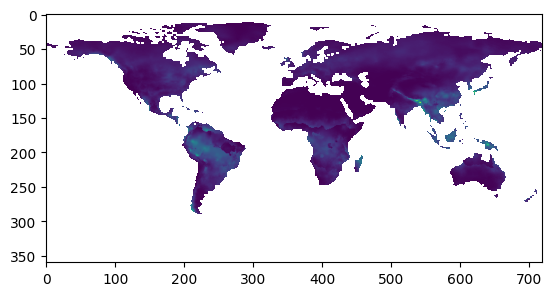

In [103]:
plt.imshow(b18);

In [279]:
## BIO19 = Precipitation of Coldest Quarter...
def bio_19(year):
    data_wet = open_netcdf(get_filename('tmn'))
    data_tmp = open_netcdf(get_filename('pre'))
    
    year_in_month = (year-1901)*12
    
    temp_wet =  data_wet.variables['tmn'][year_in_month:year_in_month+12,:,:].data
    
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(np.sum(temp_wet[i:i+3], axis=0))
    li_temp = np.array(li_temp)
    min_ind = np.argmin(li_temp, axis=0)
    
    li_q_t = []
    for i in range(0,11,3):
        li_q_t.append(np.sum(data_tmp.variables['pre'][year_in_month+i:year_in_month+i+3,:,:].data, axis=0))

    li_q_t = np.array(li_q_t)
    
    res = np.choose(min_ind, li_q_t)
    res[res > 500000] = np.nan
    res = np.flip(res,0)
    res = np.around(res, decimals=2)
    return res

In [280]:
b19 = bio_19(1980)
b19.shape

(360, 720)

In [281]:
np.nanmin(b19), np.nanmax(b19)

(0.0, 3271.5)

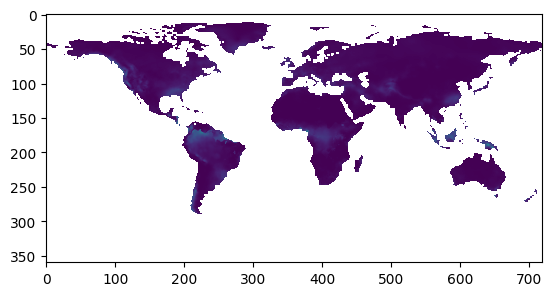

In [282]:
plt.imshow(b19);

### Create and save bioclim files for each year

In [321]:
def create_and_save_bioclim():
    for i in range(0,1):
        st = 1901+i
        os.makedirs(f"../raw_data/bioclim/{st}")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_1.csv", 
                   bio_1(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_2.csv", 
                   bio_2(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_3.csv", 
                   bio_3(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_4.csv", 
                   bio_4(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_5.csv", 
                   bio_5(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_6.csv", 
                   bio_6(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_7.csv", 
                   bio_7(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_8.csv", 
                   bio_8(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_9.csv", 
                   bio_9(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_10.csv", 
                   bio_10(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_11.csv", 
                   bio_11(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_12.csv", 
                   bio_12(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_13.csv", 
                   bio_13(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_14.csv", 
                   bio_14(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_15.csv", 
                   bio_15(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_16.csv", 
                   bio_16(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_17.csv", 
                   bio_17(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_18.csv", 
                   bio_18(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_19.csv", 
                   bio_19(st), delimiter=",")

In [ ]:
create_and_save_bioclim()

/var/folders/jj/6lhmrlt15xs297nzzcs7734w0000gn/T/ipykernel_29092/822161413.py:10: RuntimeWarning: invalid value encountered in divide
  cv = lambda x: np.std(d, ddof=1, axis=0) / np.mean(d, axis=0) * 100


### Retrieve Bioclim Data for plants

In [ ]:
def get_plant_features():
    df = pd.read_csv("/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/data_clean_subset_5_cont.csv", on_bad_lines='skip')
    #df = df[['gbifID', 'kingdom', 'species', 'scientificName', 'decimalLatitude', 'decimalLongitude','countryCode', 'year']]
    return df

In [ ]:
def get_bioclim_from_plants(df):
    df[['b1', 'b2', 'b3', 'b4', 'b5','b6','b7','b8','b9','b10','b11','b12','b13','b14',
            'b15','b16','b17','b18','b19']] = np.nan
    for i in range(len(df)):
        lat = df.loc[i, 'decimalLatitude']
        lon = df.loc[i, 'decimalLongitude']
        c_lat = int(round(np.interp(lat, [-89, 89], [359, 0])))  # check order of values here
        c_lon = int(round(np.interp(lon, [-179, 179], [1, 719])))
        df.loc[i, 'b1'] = b1[c_lat, c_lon]
        df.loc[i, 'b2'] = b2[c_lat, c_lon]
        df.loc[i, 'b3'] = b3[c_lat, c_lon]
        df.loc[i, 'b4'] = b4[c_lat, c_lon]
        df.loc[i, 'b5'] = b5[c_lat, c_lon]
        df.loc[i, 'b6'] = b6[c_lat, c_lon]
        df.loc[i, 'b7'] = b7[c_lat, c_lon]
        df.loc[i, 'b8'] = b8[c_lat, c_lon]
        df.loc[i, 'b9'] = b9[c_lat, c_lon]
        df.loc[i, 'b10'] = b10[c_lat, c_lon]
        df.loc[i, 'b11'] = b11[c_lat, c_lon]
        df.loc[i, 'b12'] = b12[c_lat, c_lon]
        df.loc[i, 'b13'] = b13[c_lat, c_lon]
        df.loc[i, 'b14'] = b14[c_lat, c_lon]
        df.loc[i, 'b15'] = b15[c_lat, c_lon]
        df.loc[i, 'b16'] = b16[c_lat, c_lon]
        df.loc[i, 'b17'] = b17[c_lat, c_lon]
        df.loc[i, 'b18'] = b18[c_lat, c_lon]
        df.loc[i, 'b19'] = b19[c_lat, c_lon]
    df.dropna(inplace=True)
    df.to_csv("/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/plant_data_inkl_bioclim.csv")
    return df

# Until here - all good

### Read .csv and dump it into numpy

#### pear year

In [ ]:
def read_csv_store_npy():
    for j in range(1901,2022):
        print(j)
        path = f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{j}/"
        fi_n = os.listdir(path)
        my_data = []
        for l in fi_n:
            my_data.append(np.genfromtxt(path+l, delimiter=','))
    with open(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim_np/yearly/{j}.npy", 'wb') as f:
        np.save(f, my_data)
    return np.array(my_data)

In [ ]:
ar = read_csv_store_npy()
ar.shape

#### all in one file

In [267]:
def read_csv_store_npy():
    all_dat = []
    for j in range(1901,1902):
        print(j)
        path = f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{j}/"
        fi_n = os.listdir(path)
        my_data = []
        for l in fi_n:
            my_data.append(np.genfromtxt(path+l, delimiter=','))
        all_dat.append(my_data)
        
    with open(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim_np/Bioclim.npy", 'wb') as f:
        np.save(f, np.array(all_dat))
    return np.array(all_dat)

In [268]:
read_csv_store_npy()

1901


array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        ...,

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan

### Retrieve Bioclim Data for plants from files

In [ ]:
df = get_bioclim_from_plants(df_init)
df.head()

In [ ]:
dd = get_plant_features()

In [ ]:
dd.head()

In [ ]:
dd.shape

In [ ]:
dd = dd[dd['year']>1901]

In [ ]:
dd.replace([np.inf, -np.inf], np.nan, inplace=True)
# Drop rows with NaN
dd.dropna(inplace=True)
dd['year'] = dd['year'].astype('int')
dd.reset_index(inplace=True, drop=True)

In [ ]:
dd.shape

In [ ]:
dd['year'] = dd['year'].astype('int')

In [ ]:
dd.drop(columns='Unnamed: 0', inplace=True)
dd

#### Dumb version from .csv - Retrieve Bioclim Data for plants from files

In [ ]:
def get_bioclim_from_plants_with_year(df):
    df[['b1', 'b2', 'b3', 'b4', 'b5','b6','b7','b8','b9','b10','b11','b12','b13','b14',
            'b15','b16','b17','b18','b19']] = np.nan
    for i in range(len(df)):
        print(i)
        
        lat = df.loc[i, 'decimalLatitude']
        lon = df.loc[i, 'decimalLongitude']
        year = int(df.loc[i, 'year'])
        c_lat = int(round(np.interp(lat, [-89, 89], [359, 0])))  # check order of values here
        c_lon = int(round(np.interp(lon, [-179, 179], [1, 719])))
        
        path = f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{year}/"
        
        filen = 'bio_1.csv'
        bio_1 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b1'] = bio_1[c_lat, c_lon]
        
        filen = 'bio_2.csv'
        bio_2 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b2'] = bio_2[c_lat, c_lon]
        
        filen = 'bio_3.csv'
        bio_3 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b3'] = bio_3[c_lat, c_lon]
        
        filen = 'bio_4.csv'
        bio_4 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b4'] = bio_4[c_lat, c_lon]
        
        filen = 'bio_5.csv'
        bio_5 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b5'] = bio_5[c_lat, c_lon]
        
        filen = 'bio_6.csv'
        bio_6 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b6'] = bio_6[c_lat, c_lon]
        
        filen = 'bio_7.csv'
        bio_7 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b7'] = bio_7[c_lat, c_lon]
        
        filen = 'bio_8.csv'
        bio_8 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b8'] = bio_8[c_lat, c_lon]
        
        filen = 'bio_9.csv'
        bio_9 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b9'] = bio_9[c_lat, c_lon]
        
        filen = 'bio_10.csv'
        bio_10 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b10'] = bio_10[c_lat, c_lon]
        
        filen = 'bio_11.csv'
        bio_11 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b11'] = bio_11[c_lat, c_lon]
        
        filen = 'bio_12.csv'
        bio_12 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b12'] = bio_12[c_lat, c_lon]
        
        filen = 'bio_13.csv'
        bio_13 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b13'] = bio_13[c_lat, c_lon]
        
        filen = 'bio_14.csv'
        bio_14 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b14'] = bio_14[c_lat, c_lon]
        
        filen = 'bio_15.csv'
        bio_15 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b15'] = bio_15[c_lat, c_lon]
        
        filen = 'bio_16.csv'
        bio_16 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b16'] = bio_16[c_lat, c_lon]
        
        filen = 'bio_17.csv'
        bio_17 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b17'] = bio_17[c_lat, c_lon]
        
        filen = 'bio_18.csv'
        bio_18 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b18'] = bio_18[c_lat, c_lon]
        
        filen = 'bio_19.csv'
        bio_19 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b19'] = bio_19[c_lat, c_lon]
        
    #df.dropna(inplace=True)
    #df.to_csv("/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/plant_data_inkl_bioclim.csv")
    return df

In [ ]:
bio_clim_df = get_bioclim_from_plants_with_year(dd)

#### Retrieve Bioclim Data for plants from files - .npy file

In [ ]:
def get_plant_features():
    df = pd.read_csv("/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/data_clean_5_continent_Animal_plants.csv", on_bad_lines='skip')
    return df

In [ ]:
dd_set = get_plant_features()

In [ ]:
dd_set = dd_set[(dd_set['year']>=1901) & (dd_set['year']<=2021)]
dd_set.reset_index(inplace=True)

In [ ]:
dd_set.head()

In [ ]:
dd_set.shape

In [ ]:
def get_bioclim_from_plants(df):
    #df[['b1', 'b2', 'b3', 'b4', 'b5','b6','b7','b8','b9','b10','b11','b12','b13','b14',
     #       'b15','b16','b17','b18','b19']] = np.nan
    
    path = f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim_np/"
    filen = 'bioclim.npy'
    bioclim = np.load(path+filen)
    
    for i in range(len(df)):
        print(i)
        
        lat = df.loc[i, 'decimalLatitude']
        lon = df.loc[i, 'decimalLongitude']
        year = int(df.loc[i, 'year'])
        
        c_lat = int(round(np.interp(lat, [-90, 90], [360, 0])))  # check order of values here
        c_lon = int(round(np.interp(lon, [-180, 180], [1, 719])))
        lli = []
        for j in range(19):
            val_temp = bioclim[year-1901, j, c_lat, c_lon]
            if np.isnan(val_temp):
                try:
                    a = ([bioclim[year-1901, j, c_lat-1, c_lon], 
                           bioclim[year-1901, j, c_lat+1, c_lon],
                           bioclim[year-1901, j, c_lat, c_lon-1],
                           bioclim[year-1901, j, c_lat, c_lon+1],
                            bioclim[year-1901, j, c_lat+1, c_lon+1],
                            bioclim[year-1901, j, c_lat-1, c_lon-1],
                            bioclim[year-1901, j, c_lat-1, c_lon+1],
                            bioclim[year-1901, j, c_lat+1, c_lon-1],
                         bioclim[year-1901, j, c_lat+2, c_lon],
                         bioclim[year-1901, j, c_lat-2, c_lon],
                         bioclim[year-1901, j, c_lat, c_lon-2],
                         bioclim[year-1901, j, c_lat, c_lon-2]])
                    if np.isnan(a).sum()==12:    
                        val_temp = np.nan
                    else:
                        val_temp = np.nanmean(a)
                except:
                    continue

            df.loc[i, f"b{j+1}"] = val_temp
    #df.dropna(inplace=True)
    df.to_csv("/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/data_inkl_bioclim_grs.csv")
    return df

In [ ]:
ddd = get_bioclim_from_plants(dd_set)
ddd.shape

In [ ]:
ddd=ddd.dropna(subset=['b1'])

In [ ]:
ddd.to_csv("/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/data_inkl_bioclim_grs.csv")

In [ ]:
ddd.shape

#### Lon/Lat tests

In [ ]:
ddd.loc[27528, 'decimalLatitude']

In [ ]:
ddd.loc[27528, 'decimalLongitude']

In [ ]:
path = f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim_np/"
filen = 'bioclim.npy'
bioclim = np.load(path+filen)

In [ ]:
lat = 12.1656677
lon = -83.053017

c_lat = int(round(np.interp(lat, [-89, 89], [360, 0])))  # check order of values here
c_lon = int(round(np.interp(lon, [-179, 179], [1, 719])))

In [ ]:
c_lat, c_lon

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(bioclim[0,0,:,:])
plt.plot(c_lon,c_lat, marker='.', color="red");

In [ ]:
bioclim[0,0,c_lat-2,c_lon-2]

### Create DF for Clim Dataset of all exising lon/lat vals

In [ ]:
path = f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim_np/"
filen = 'bioclim.npy'
bioclim = np.load(path+filen)

In [ ]:
def get_all_climate_lon_lat():
    li_hist_df = []
    for g in range(121):
        li_clim = []
        li_lon_lat_years = []
        li_lon_lat = []
        li_lon_lon = []
        for i in range(360):
            for j in range(720):
                li_temp = []
                for k in range(19):
                    li_temp.append(bioclim[g,k,i,j])
                li_lon_lat_years.append(f"{g}")
                li_lon_lat.append(f"{i}")
                li_lon_lon.append(f"{j}")
                li_clim.append(li_temp)
        aa = np.stack((np.array(li_lon_lat_years), np.array(li_lon_lat), np.array(li_lon_lon)))
        aa = np.transpose(aa)
        cc = np.array(li_clim)
        uu = np.hstack((aa, cc))
        xx = pd.DataFrame(uu)
        xx = xx[xx[3].str.contains("nan")==False]
        li_hist_df.append(xx.to_numpy())
    return np.array(li_hist_df)

In [ ]:
d = get_all_climate_lon_lat()
d.shape

In [ ]:
pd.DataFrame(d[0])

In [ ]:
with load(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/world_history_bioclim_allLatLon.npy") as f:
        np.save(f, d)

### Create DF for Soilgrid Dataset of all exising lon/lat vals

In [ ]:
data = np.load("/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/soil_data.npy")

In [ ]:
data.shape

In [ ]:
def get_all_soilgrid_lon_lat():
    li_clim = []
    li_lon_lat = []
    li_lon_lon = []
    for i in range(360):
        for j in range(720):
            li_temp = []
            for k in range(60):
                li_temp.append(data[k,i,j])
            li_lon_lat.append(f"{i}")
            li_lon_lon.append(f"{j}")
            li_clim.append(li_temp)
    aa = np.column_stack((li_lon_lat, li_lon_lon, li_clim))
    xx = pd.DataFrame(aa)
    xx.drop(xx[xx[2] == '0'].index, inplace = True)
    return xx

In [ ]:
bx = get_all_soilgrid_lon_lat()
bx.shape

In [ ]:
with open("/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/world_soilgrid_allLatLon.npy", 'wb') as f:
        np.save(f, bx)

### Merge bioclim and soilgrid df in order to interpolate soilgrid

In [ ]:
data = np.load("/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/soil_data.npy")

In [ ]:
data.shape

In [ ]:
def get_all_climate_grid_lon_lat():
    li_clim = []
    li_lon_lat = []
    li_lon_lon = []
    for i in range(360):
        for j in range(720):
            li_temp = []
            for k in range(19):
                li_temp.append(bioclim[0,k,i,j])
            for u in range(60):
                li_temp.append(data[k,i,j])
            
            li_lon_lat.append(f"{i}")
            li_lon_lon.append(f"{j}")
            li_clim.append(li_temp)
                
    aa = np.stack((np.array(li_lon_lat), np.array(li_lon_lon)))
    aa = np.transpose(aa)
    cc = np.array(li_clim)
    uu = np.hstack((aa, cc))
    xx = pd.DataFrame(uu)
    xx = xx[xx[3].str.contains("nan")==False]
    xx.columns = [np.arange(0,81)]
    xx = xx.drop(xx.columns[np.arange(2,21)],axis = 1)
    xx.columns = [np.arange(0,62)]
    return xx

In [ ]:
bb = get_all_climate_grid_lon_lat()
bb.shape

In [ ]:
with open("/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/world_soilgrid_allLatLon_withzeros.npy", 'wb') as f:
        np.save(f, bx)

# GBIF - multimedia - DF inkl. scraping

## Merge DFs

In [75]:
df_m = pd.read_csv('/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/multimedia.txt', sep='\t', index_col='gbifID')

/var/folders/jj/6lhmrlt15xs297nzzcs7734w0000gn/T/ipykernel_18579/3636303481.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_m = pd.read_csv('/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/multimedia.txt', sep='\t', index_col='gbifID')


In [3]:
df_m = df_m[['identifier']]

In [4]:
df = pd.read_csv("/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/data_inkl_bioclim_grs.csv")
df = df.set_index('gbifID')

In [5]:
media_df = df.merge(df_m,  left_index=True, right_index=True)

In [6]:
media_df.shape

(207948, 38)

In [7]:
media_df = media_df[['identifier']]
media_df.shape

(207948, 1)

In [8]:
media_df

,identifier
gbifID,
196091903,http://www1.pms-lj.si/animalia/media/Ctenophth...
231538729,https://app.coeli.cat/coeli/ICUB-NAT/HeritageO...
231538730,https://app.coeli.cat/coeli/ICUB-NAT/HeritageO...
231539510,https://app.coeli.cat/coeli/ICUB-NAT/HeritageO...
231539622,https://app.coeli.cat/coeli/ICUB-NAT/HeritageO...
...,...
3981058908,https://data.nhm.ac.uk/media/6b7e383a-a772-42f...
3981058908,https://data.nhm.ac.uk/media/527a3e51-3225-420...
3981058908,https://data.nhm.ac.uk/media/720f85ea-d413-4a0...


In [9]:
media_df.to_csv("/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/url_df_selection.csv")

## Download Images, crop and resize

In [ ]:
def crop_max_square(pil_img):
    return crop_center(pil_img, min(pil_img.size), min(pil_img.size))

In [ ]:
def crop_center(pil_img, crop_width, crop_height):
    img_width, img_height = pil_img.size
    return pil_img.crop(((img_width - crop_width) // 2,
                         (img_height - crop_height) // 2,
                         (img_width + crop_width) // 2,
                         (img_height + crop_height) // 2))

### scrap images - check if already there beforehand

In [ ]:
fold_n_thumb = '/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/thumbnails/'
fi_n = os.listdir(fold_n_thumb)
#fi_n.remove('.DS_Store')
files = [os.path.splitext(filename)[0] for filename in os.listdir(fold_n_thumb)]
#files.remove('.DS_Store')

media_df_nodupl = media_df[~media_df.index.duplicated(keep='first')]
list_indexes = media_df_nodupl.index
diff_li = list(set(list_indexes) - set(files))
random.shuffle(diff_li)

for i in range(0, 1000):
    try:
        r = requests.get(media_df_nodupl.loc[int(diff_li[i]),'identifier'], stream=True) #Get request on full_url
        with open(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/images/{int(diff_li[i])}.jpg", 'wb') as f: 
            r.raw.decode_content = True
            shutil.copyfileobj(r.raw, f)
    except:
        continue
        
    time.sleep(random.uniform(0.5, 1))

### crop and scale images

In [109]:
fold_n_im = '/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/images/'
fi_n = os.listdir(fold_n)
fi_n.remove('.DS_Store')

for i in range(len(fi_n)):
    try:
        image = Image.open(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/images/{fi_n[i]}")
        image = crop_max_square(image).resize((300, 300))
        image.save(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/thumbnails/{fi_n[i]}") 
    except:
        continue

# Tests

In [177]:
a = pd.read_csv('/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/plant_data_inkl_bioclim_101.csv')

In [178]:
a.describe()

,Unnamed: 0,gbifID,decimalLatitude,decimalLongitude,year,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,b15,b16,b17,b18,b19
count,185255.00000,1.852550e+05,185255.000000,185255.000000,185255.000000,185255.000000,185255.000000,185255.000000,185255.000000,185255.000000,185255.000000,185255.000000,185255.000000,185255.000000,185255.000000,185255.000000,185255.000000,185255.000000,185255.000000,185255.000000,185255.000000,185255.000000,185255.000000,185255.000000
mean,166460.81947,1.415263e+09,8.125530,-18.937266,1945.405004,19.674663,11.308403,0.606118,3.123837,30.275407,9.251552,21.023855,19.833827,19.526343,23.188930,16.360742,1501.484649,256.013596,27.528261,78.421258,596.557924,172.762070,404.548244,280.774157
std,95923.64824,7.249819e+08,23.715638,86.940588,45.843913,6.880434,3.052137,0.182492,2.955120,4.775633,10.760217,9.756628,8.337329,7.667090,4.843687,9.728919,1009.684429,154.949116,38.209374,34.312089,378.473947,185.025293,312.345286,307.819721
min,0.00000,5.803830e+05,-54.980000,-179.170000,1700.000000,-24.566668,2.741667,0.137097,0.167498,-4.200000,-47.900002,6.799999,-27.733335,-32.899998,-14.866666,-37.333336,0.200000,0.000000,0.000000,13.932714,0.000000,0.000000,0.000000,0.000000
25%,79108.50000,1.019733e+09,-9.436314,-82.642888,1912.000000,16.099998,9.083333,0.474555,0.777282,28.100000,2.800000,13.100002,15.700001,16.199999,20.233332,11.599999,710.099976,128.400009,1.000000,53.611343,281.600006,37.200001,161.200012,73.900002
50%,170972.00000,1.259052e+09,7.000000,-63.486400,1950.000000,21.566666,10.791667,0.617850,1.992277,31.300001,11.300000,18.000000,23.000000,21.700003,24.500000,19.133333,1252.000122,239.100006,13.300000,69.710541,531.799988,109.100006,346.799988,172.699997
75%,246118.50000,1.929824e+09,26.520000,37.633300,1983.000000,25.333334,13.141666,0.760312,4.799530,32.900002,18.200001,27.299999,25.900002,25.266668,26.833334,24.166666,2133.900146,355.100006,36.500000,97.846672,864.500000,237.100006,600.100037,401.299988
max,329202.00000,3.986730e+09,82.000000,179.943611,2021.000000,30.483335,24.099998,0.935055,21.221550,46.200001,25.100000,70.400002,34.266666,35.766666,35.766666,29.166666,7858.200195,1653.900024,468.899994,346.410187,3352.500000,1493.400146,3352.500000,3053.200195


In [269]:
path = f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim_np/"
filen = 'bioclim.npy'
bioclim = np.load(path+filen)

In [270]:
bioclim.shape

(1, 19, 360, 720)

In [273]:
np.nanmin(bioclim[0,8,:,:])

0.0

In [278]:
dddd = np.load("/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/1901/bio_7.csv")

ValueError: Cannot load file containing pickled data when allow_pickle=False

In [275]:
dddd.shape

(359, 720)

In [257]:
np.nanmax(dddd.to_numpy())

72.5999984741211